<a href="https://colab.research.google.com/github/nielsrolf/GAN-TUBerlin/blob/master/colab_gan_that_imports_from_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Clone or update the repo, then import it, get the data and plot it

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


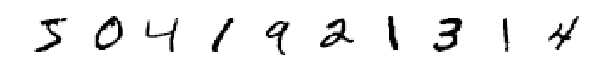

In [3]:
%load_ext autoreload
%autoreload 2

from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)
PROJ = "My Drive/gan_tu" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)


regular_training = False
unconnected_support_prior = False
train_d_more_often = False

from importlib.machinery import SourceFileLoader
gan = SourceFileLoader('gan', join(PROJECT_PATH, 'gan.py')).load_module()
callbacks = SourceFileLoader('callbacks', join(PROJECT_PATH, 'callbacks.py')).load_module()


GradientInverser = gan.GradientInverser
DCGAN = gan.DCGAN
Uniform = gan.Uniform
Unconnected = gan.Unconnected
AutoencodingGAN = gan.AutoencodingGAN

OverfittingCallback = callbacks.OverfittingCallback   
InverseDistributionCallback = callbacks.InverseDistributionCallback
EvolvingImageCallback = callbacks.EvolvingImageCallback
InterpolationCallback = callbacks.InterpolationCallback
show = callbacks.show


from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import sys
import numpy as np

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_test = X_test / 127.5 - 1.

X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])

X_train.shape
callbacks.show(X_train[:10])

# transform it to one hot encoding
Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]


# Regular Training

In [0]:
if regular_training:
    dcgan = gan.DCGAN(gan.Uniform(100))



    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

# Unconnected Support Prior

In [0]:
if unconnected_support_prior:
    dcgan = gan.DCGAN(gan.Unconnected(100))


    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist_u'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period),
        (ModeCollapseObserver(dcgan, get_mnist_predictor()), period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

The assumption is wrong.

# Autoencoding GAN

We can combine the GAN with an Autoencoder, where the generator is used as decoder. This can either be done by only training an additional encoder, or by training the generator to optimize both objectives, that of the autoencoder and that of the GAN setup.

We then have two different ways to invert a GAN, which we can compare. It will show that both methods yield quite different encodings, however yield in similar decoded images. This indicates that there are areas in z space that are all mapped to similar output in x space. Applying the difference of two encodings of the same image to another image shows, that the effect is here much bigger, which shows that the encodings don't differ in a dimension or length that the generator is in general invariant to, but that at different areas of the latent space, certain directions have a small gradient with respect to G.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train reconstruction


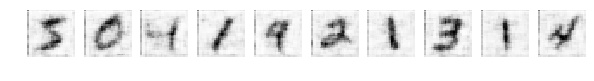

Original Train


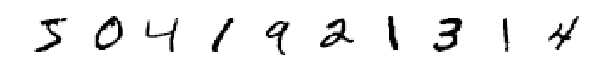

Test reconstruction


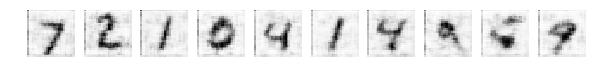

Original Test


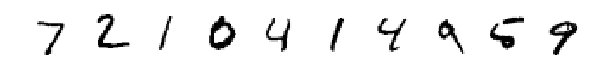

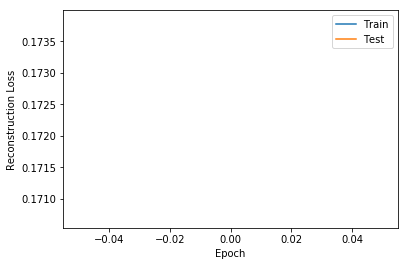

Train reconstruction


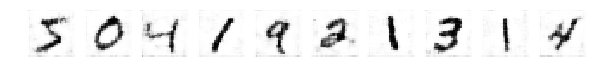

Original Train


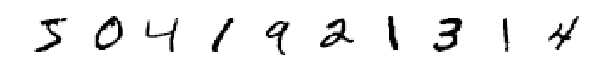

Test reconstruction


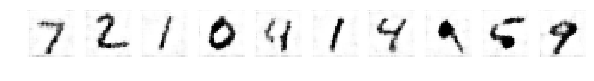

Original Test


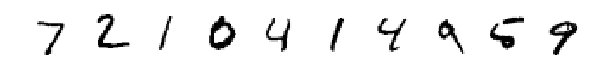

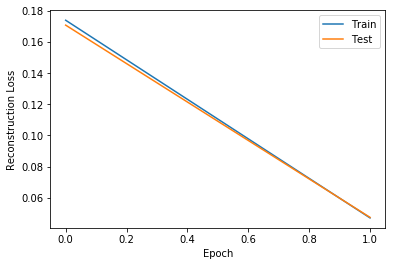

Train reconstruction


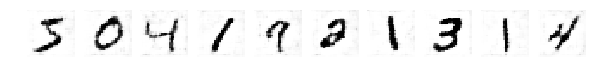

Original Train


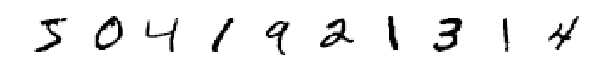

Test reconstruction


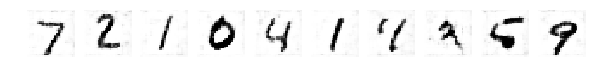

Original Test


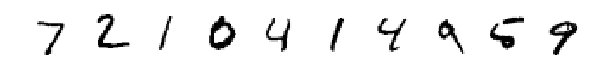

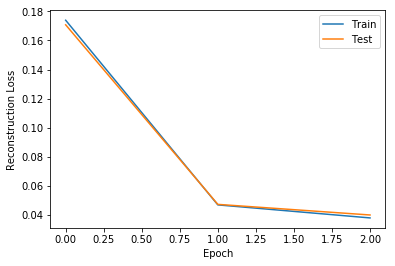

Train reconstruction


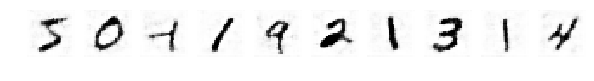

Original Train


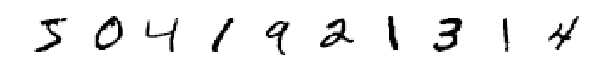

Test reconstruction


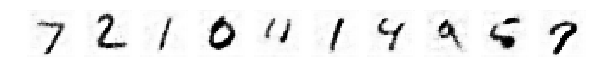

Original Test


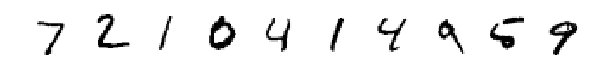

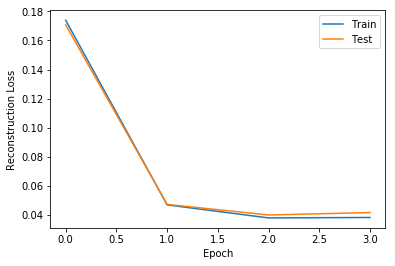

Train reconstruction


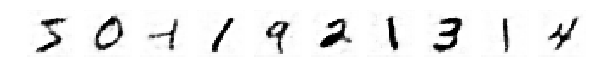

Original Train


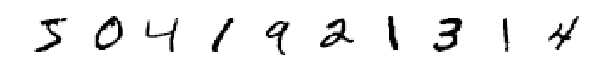

Test reconstruction


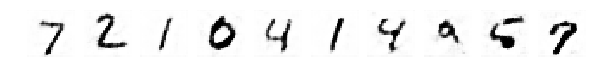

Original Test


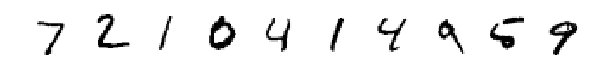

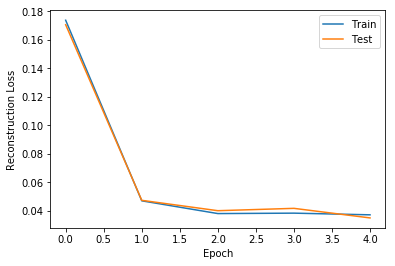

Train reconstruction


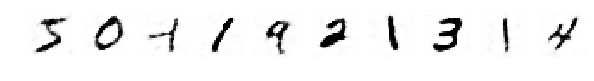

Original Train


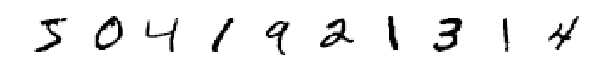

Test reconstruction


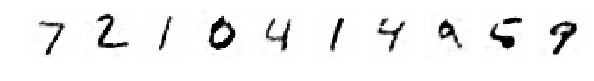

Original Test


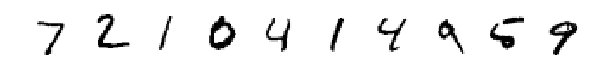

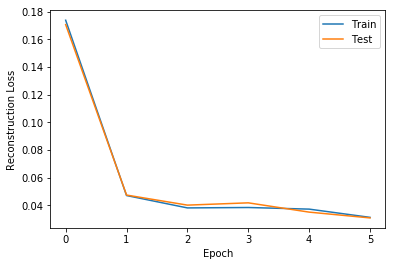

Train reconstruction


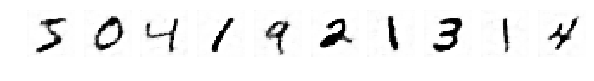

Original Train


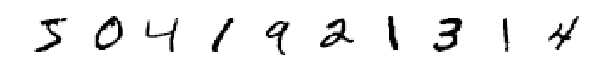

Test reconstruction


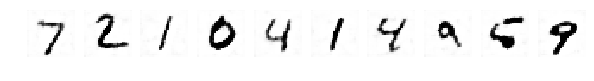

Original Test


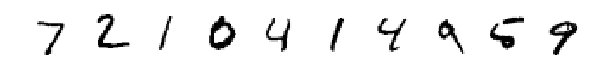

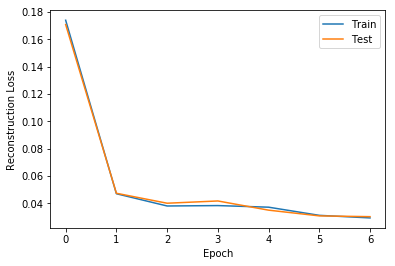

Train reconstruction


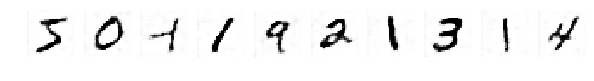

Original Train


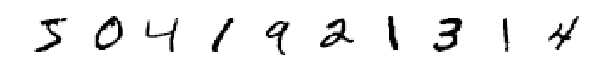

Test reconstruction


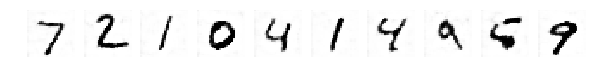

Original Test


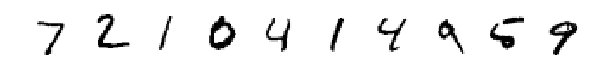

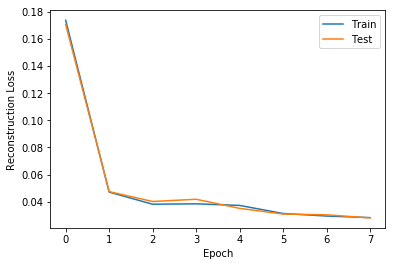

KeyboardInterrupt: ignored

In [4]:
dcgan = DCGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(dcgan, X_train[:100], X_test[:100])
train_callbacks = [
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1)
]

dcgan.train(X_train[:1280], epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

## Train additional encoder without changing GAN training

In [0]:
aegan = AutoencodingGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

## Include generator in Aeutoencder training

Train reconstruction


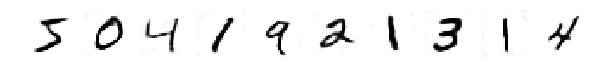

Original Train


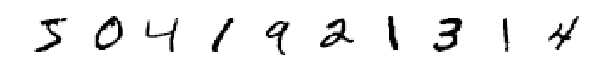

Test reconstruction


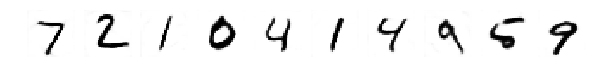

Original Test


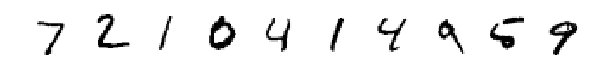

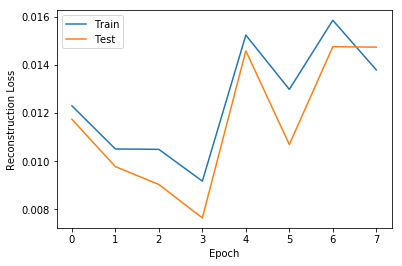

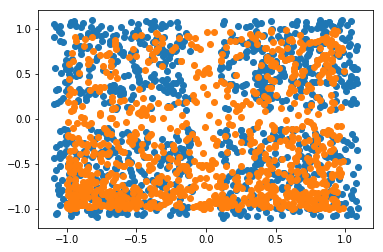

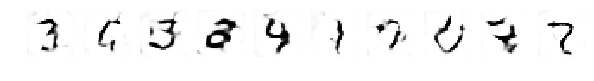

Train reconstruction


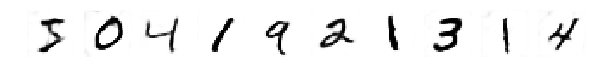

Original Train


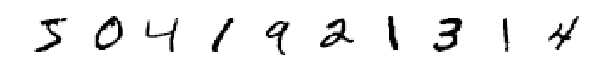

Test reconstruction


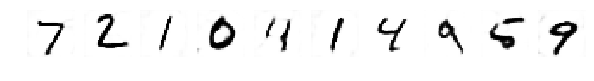

Original Test


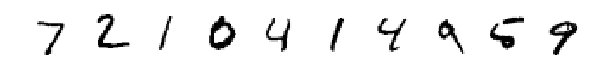

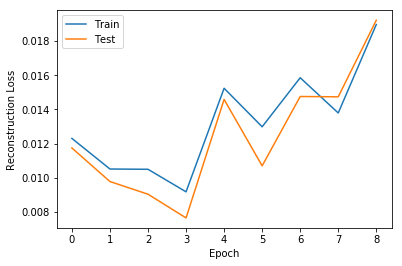

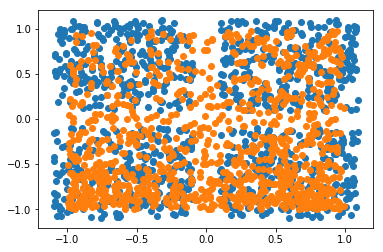

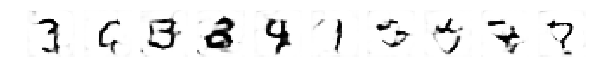

Train reconstruction


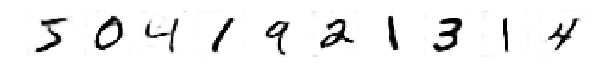

Original Train


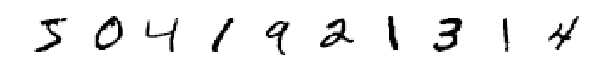

Test reconstruction


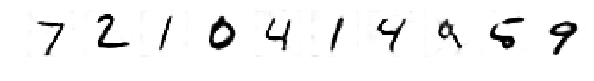

Original Test


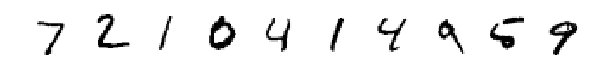

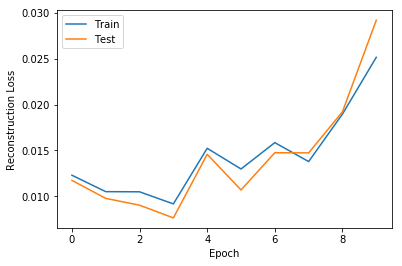

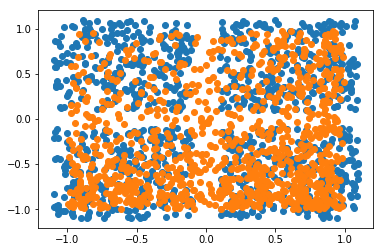

In [5]:
aegan = AutoencodingGAN(gan.Unconnected(100), train_decoder=True)

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

[autoreload of callbacks failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'name'
]


Distance between found encodings 23.350234151047058
Gradient Based Reconstruction


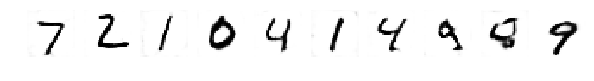

Autoencoder Based Reconstruction


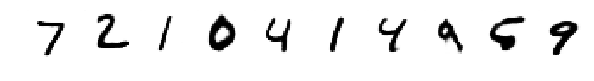

AE  MSE: 0.05514446788045608 
GAN MSE: 0.029878724954635852


In [6]:
# Compare GradientInverser and Encoder

gradient_inverter = GradientInverser(aegan)
samples = X_test[:10]
z_g = gradient_inverter.invert(samples)
z_ae = aegan.encode(samples)
print('Distance between found encodings', np.linalg.norm(z_g - z_ae))
print('Gradient Based Reconstruction')
x_g = aegan.generate(z_g)
show(x_g)
print('Autoencoder Based Reconstruction')
x_ae = aegan.generate(z_ae)
show(x_ae)
print(f"AE  MSE: {np.mean(np.square(x_ae-samples))} \nGAN MSE: {np.mean(np.square(x_g-samples))}")




Interpolation between reconstructions
------------------


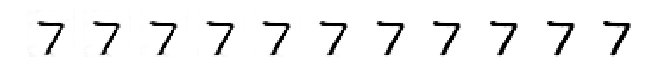

Distance in z/norm(z_g): 1.27
Distance in x/norm(x): 0.18
Distance after applying transformation to next sample 0.4839614553045071


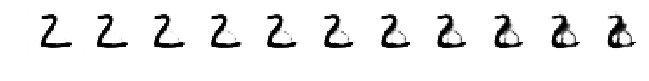

------------------


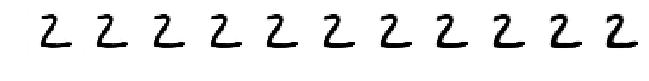

Distance in z/norm(z_g): 0.89
Distance in x/norm(x): 0.30
Distance after applying transformation to next sample 0.6211842953179838


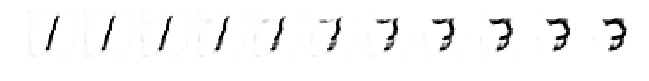

------------------


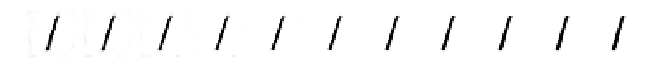

Distance in z/norm(z_g): 1.42
Distance in x/norm(x): 0.12
Distance after applying transformation to next sample 0.5537489646886539


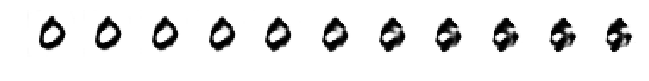

------------------


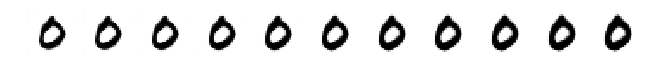

Distance in z/norm(z_g): 1.02
Distance in x/norm(x): 0.29
Distance after applying transformation to next sample 0.5788699017257543


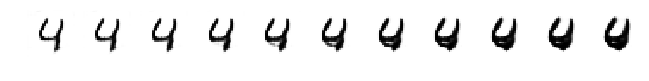

------------------


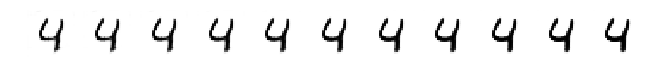

Distance in z/norm(z_g): 0.88
Distance in x/norm(x): 0.20
Distance after applying transformation to next sample 0.303711796027253


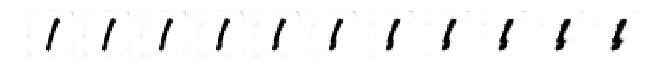

In [7]:
print("Interpolation between reconstructions")

def interpolate(generate, z0, z1):
    b = z0[None,...]
    a = z1[None,...] - b
    x = np.arange(0, 1.05, 0.1)[...,None]
    z = a*x + b
    show(generate(z))

for i in range(5):
    print("------------------")
    interpolate(aegan.generate, z_g[i], z_ae[i])
    print(f"Distance in z/norm(z_g): {np.linalg.norm(z_g[i] - z_ae[i])/np.linalg.norm(z_g[i]):.2f}\n"
         f"Distance in x/norm(x): {np.linalg.norm(x_g[i]-x_ae[i])/np.linalg.norm(samples[i]):.2f}\n"
         "Distance after applying transformation to next sample",
         np.linalg.norm(aegan.generate(z_g[i+1][None,...]) - 
                        aegan.generate((z_g[i+1] -  z_g[i] + z_ae[i])[None,...]))/np.linalg.norm(samples[i+1]))
    interpolate(aegan.generate, z_g[i+1],  z_g[i+1] -  z_g[i] + z_ae[i])
    

We can find the most discriminative 2D embedding for z or for x space by training a classifier that first projects into the 2D embedding space, and then classifies the labels of our images.

In order to proof the idea, we start with an embedding for x space.

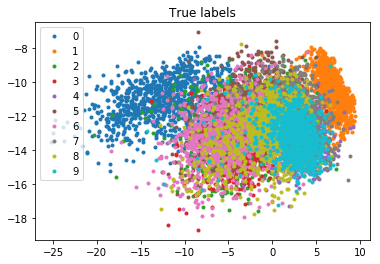

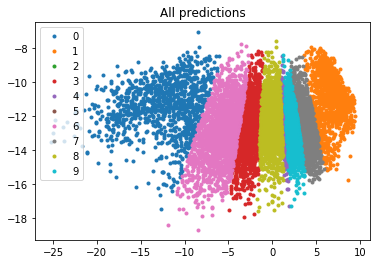

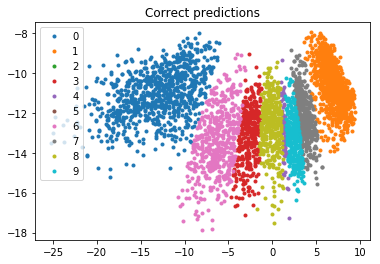

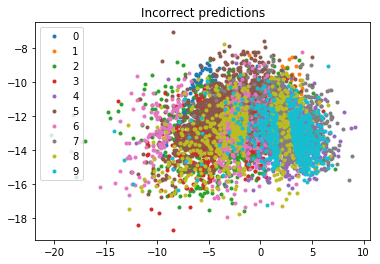

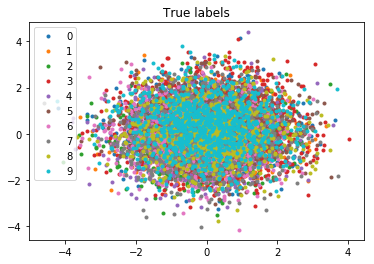

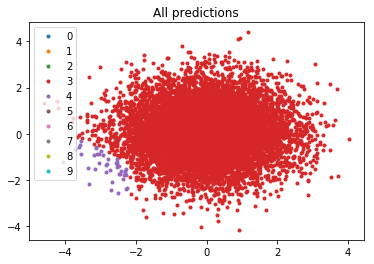

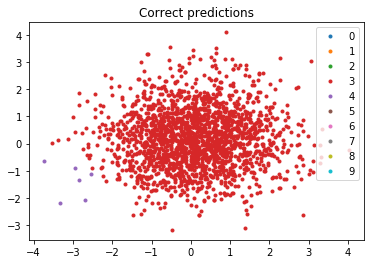

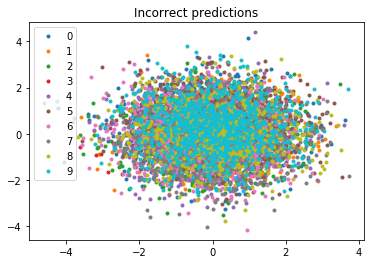

In [20]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten

class Embedding():
    # 2D projection of a distribution that preserves labelinformation
    def __init__(self, x, y, load_from=None, save_to=None):
        try:
            embedding_model = load_model(load_from)
        except Exception as e:
            embedding_model = Sequential()
            embedding_model.add(Flatten(input_shape=x.shape[1:]))
            embedding_model.add(Dense(2))
            embedding_model.add(Dense(2048, activation='relu'))
            embedding_model.add(Dense(10, activation='sigmoid'))
            embedding_model.summary()
            embedding_model.compile(loss='binary_crossentropy', optimizer='sgd',  metrics=['acc'])
            embedding_model.fit(x, y, epochs=8)
            if save_to is not None:
                embedding_model.save(save_to)
        self.to2d = Model(embedding_model.inputs[0], embedding_model.layers[1].output).predict
        self.predict = embedding_model.predict
        
    def plot_true_labels(self, x, y):
        x_2d = self.to2d(x)
        for digit in range(10):
            x_of_digit = x_2d[y.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title("True labels")
        plt.legend()
        plt.show()
        
    def plot_eval(self, x, y):
        x_2d = self.to2d(x)
        Y_pred = self.predict(x)
        for digit in range(10):
            x_of_digit = x_2d[Y_pred.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title('All predictions')
        plt.legend()
        plt.show()

        Y_pred = self.predict(x)
        correct = x[Y_pred.argmax(1)==y.argmax(1)]
        correct2d = self.to2d(correct)
        Y_pred = self.predict(correct)
        for digit in range(10):
            x_of_digit = correct2d[Y_pred.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title('Correct predictions')
        plt.legend()
        plt.show()

        Y_pred = self.predict(x)
        incorrect = x[Y_pred.argmax(1)!=y.argmax(1)]
        incorrect2d = self.to2d(incorrect)
        Y_true = y[Y_pred.argmax(1)!=y.argmax(1)]
        for digit in range(10):
            x_of_digit = incorrect2d[Y_true.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title('Incorrect predictions')
        plt.legend()
        plt.show()


x_embedding = Embedding(X_train, Y_train, load_from='x_embedding.h5')
x_embedding.plot_true_labels(X_test, Y_test)
x_embedding.plot_eval(X_test, Y_test)

z = aegan.prior(10000)
fakes = aegan.generate(z)
mnist_predictor = load_model(f"{PROJECT_PATH}/mnist_predictor.h5")
labels = mnist_predictor.predict(fakes)
z_embedding = Embedding(z, labels, load_from='z_embedding.h5')
z_embedding.plot_true_labels(z, labels)
z_embedding.plot_eval(z, labels)

In [18]:
(mnist_predictor.predict(X_test).argmax(1) == Y_test.argmax(1)).mean()

0.9917

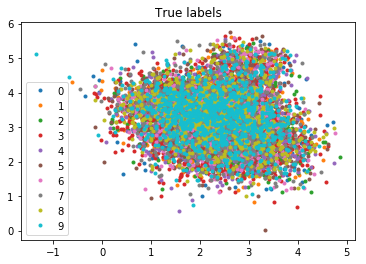

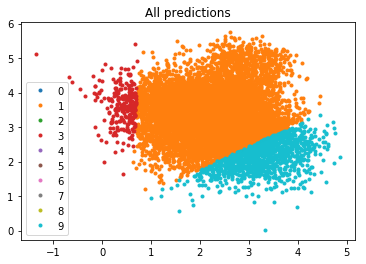

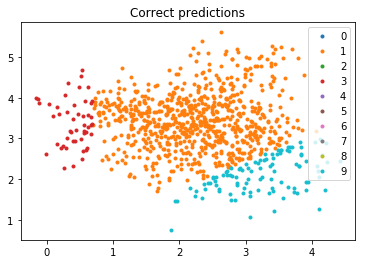

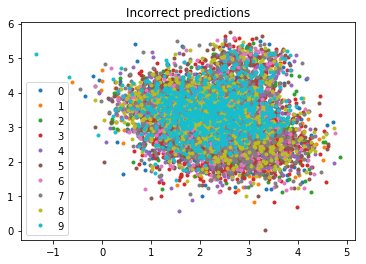

In [25]:
z = aegan.encode(X_train[:10000])
z_embedding = Embedding(z, Y_train[:10000], load_from='z_embedding.h5')
z_embedding.plot_true_labels(z, labels)
z_embedding.plot_eval(z, labels)

## Train vanilla Autoencoder

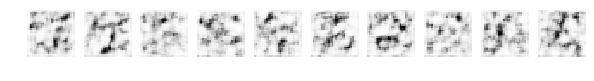

Train reconstruction


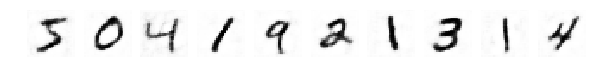

Original Train


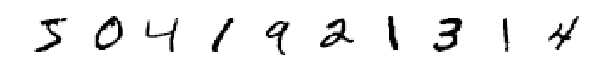

Test reconstruction


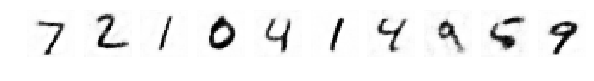

Original Test


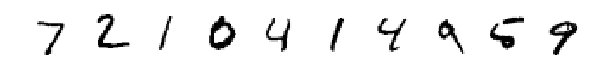

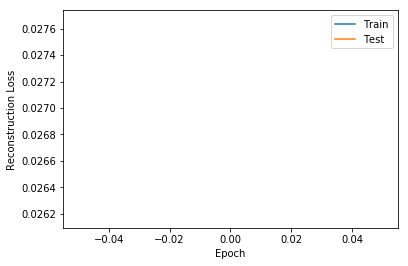

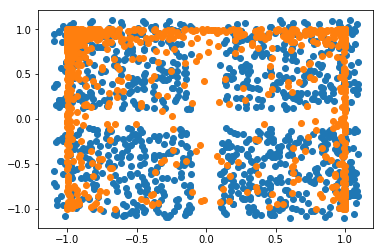

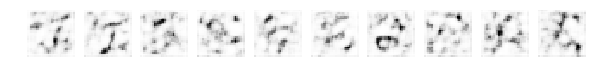

Train reconstruction


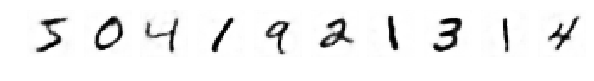

Original Train


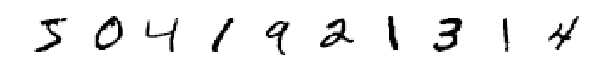

Test reconstruction


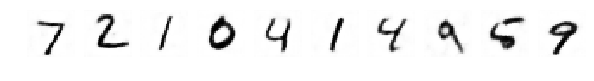

Original Test


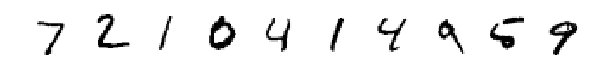

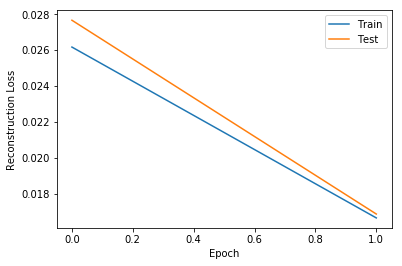

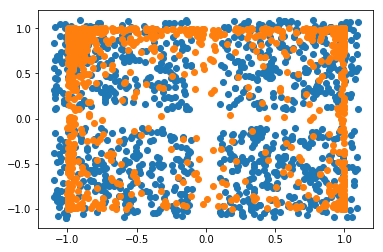

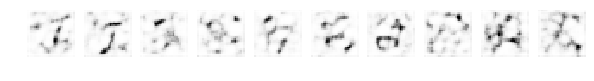

Train reconstruction


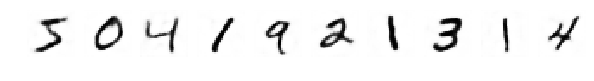

Original Train


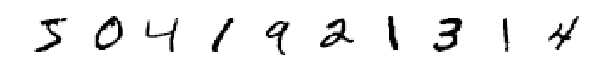

Test reconstruction


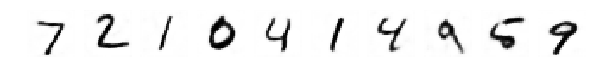

Original Test


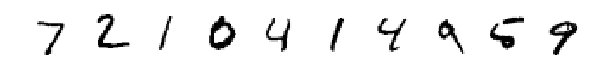

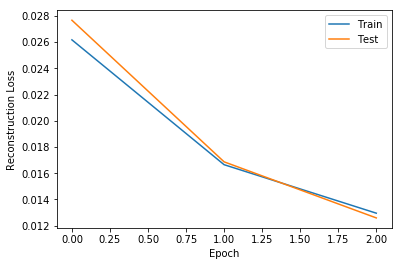

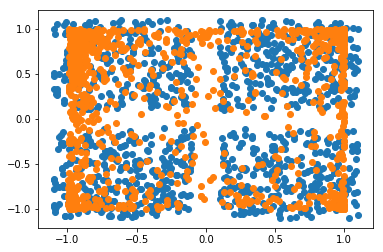

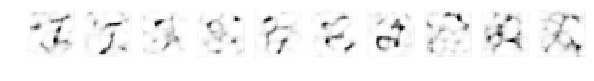

Train reconstruction


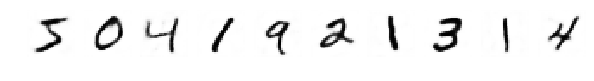

Original Train


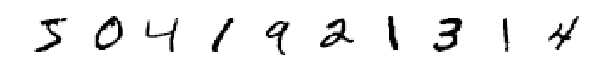

Test reconstruction


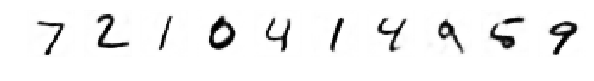

Original Test


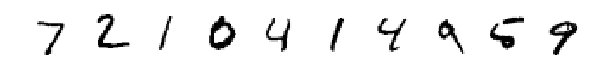

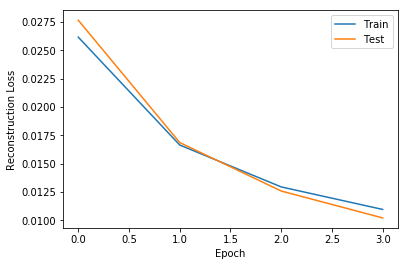

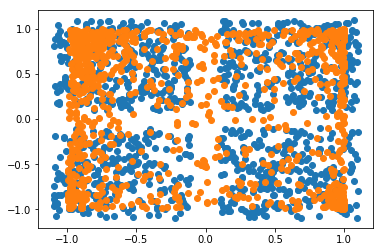

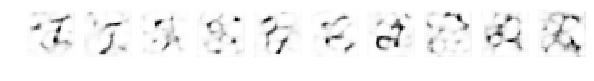

Train reconstruction


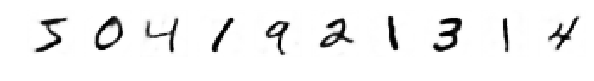

Original Train


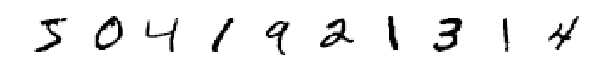

Test reconstruction


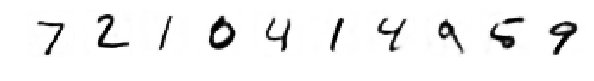

Original Test


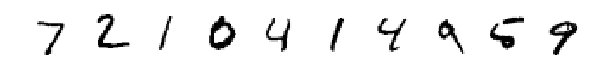

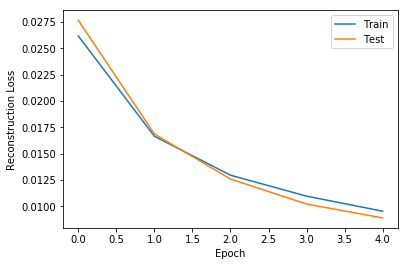

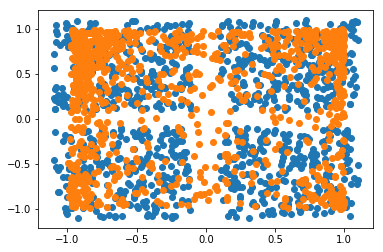

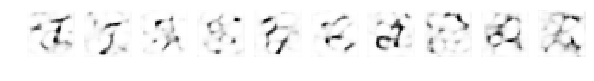

Train reconstruction


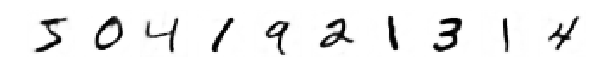

Original Train


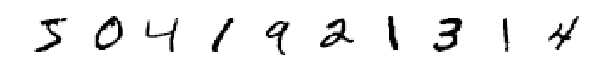

Test reconstruction


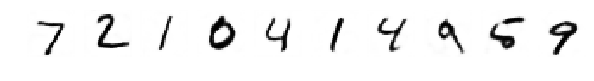

Original Test


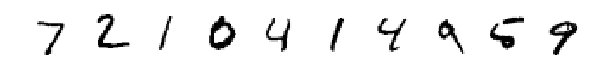

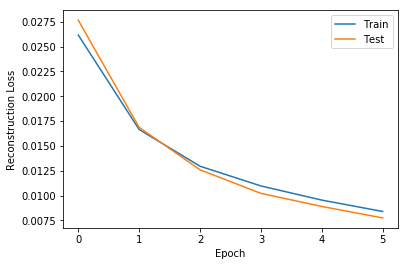

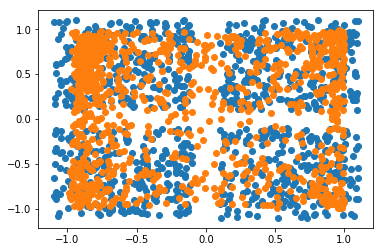

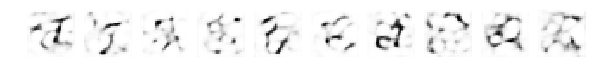

Train reconstruction


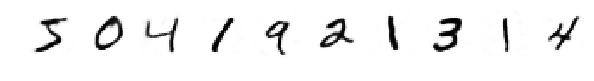

Original Train


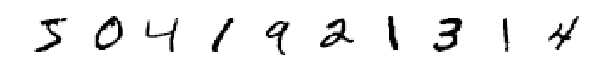

Test reconstruction


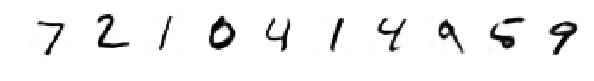

Original Test


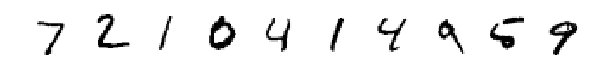

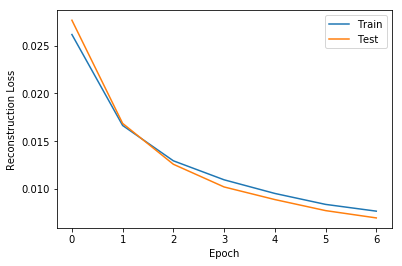

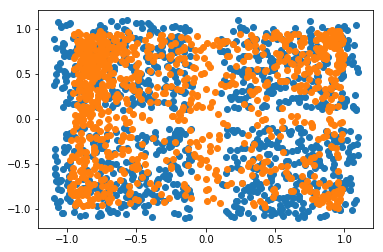

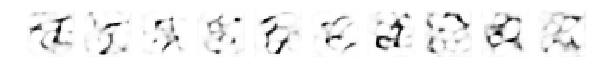

Train reconstruction


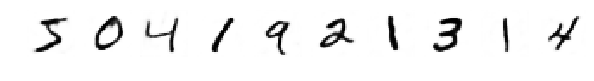

Original Train


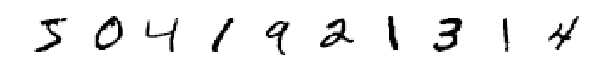

Test reconstruction


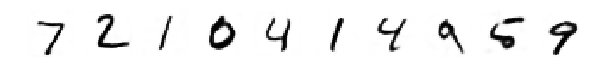

Original Test


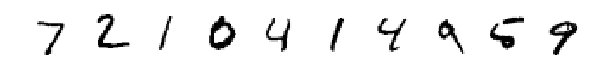

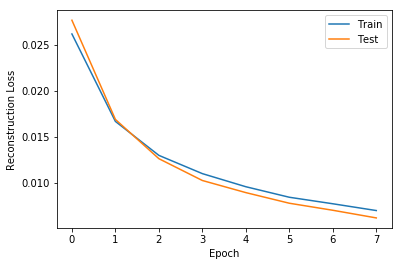

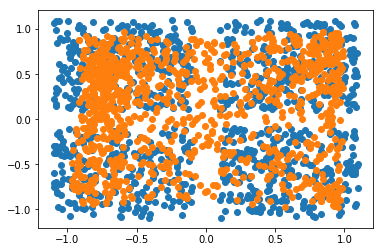

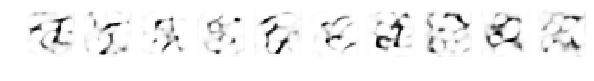

Train reconstruction


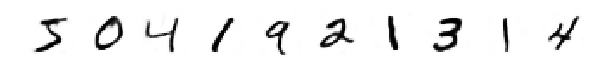

Original Train


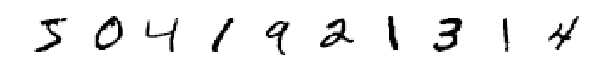

Test reconstruction


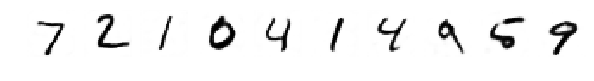

Original Test


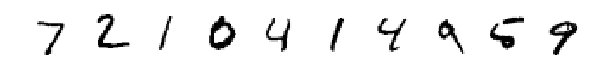

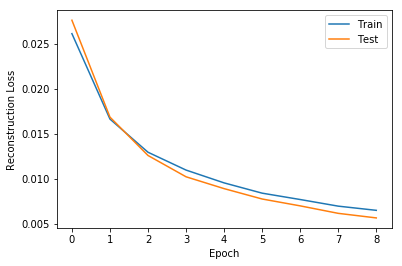

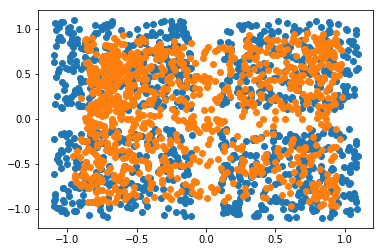

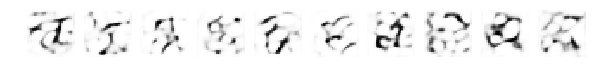

Train reconstruction


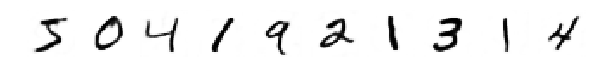

Original Train


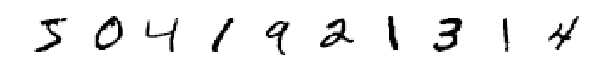

Test reconstruction


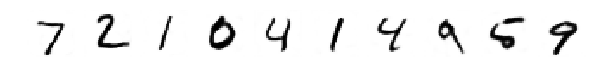

Original Test


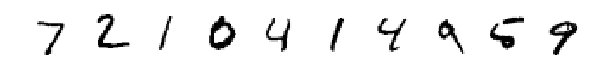

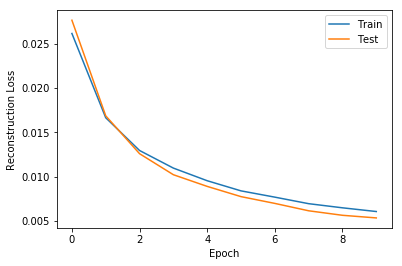

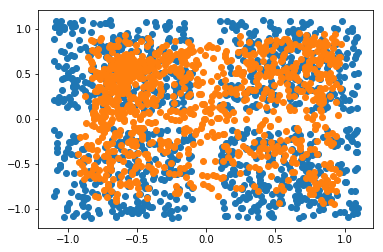

In [22]:
aegan = AutoencodingGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=0, g_steps=0)